# <ins> Prédiction de l'émission de CO2 (TotalGHGEmissions) </ins>

Import des bibliothèques 

In [ ]:
!pip install plotly  #Installation de plotly pour l'affichage des certains graphiques

In [69]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import plotly.graph_objects as go
import warnings
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import *
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import *
from sklearn.dummy import DummyRegressor
from sklearn.svm import LinearSVR
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor
from sklearn import set_config
set_config(display='diagram')
from sklearn.ensemble import *
warnings.filterwarnings('ignore')

#plot distribution de la target et voir le scaler à utiliser 

Téléchargement du jeu de données

In [70]:
data_model =pd.read_csv('https://raw.githubusercontent.com/bachir151/Projet-openclassrooms/master/P3/data.csv',on_bad_lines='skip')
data_model =data_model.drop(['Unnamed: 0'], axis=1)
#data_model =data_model.drop(['index'], axis=1)
data_model.head()

,SiteEnergyUse(kBtu),TotalGHGEmissions,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,age_batiment,LargestPropertyUseType,...,BuildingType,Ratio_buildingParSurface,Ratio_parkingParSurface,SurfaceParetage,ComplianceStatus,Outlier,is_energyStarImputed,pr_steam,pr_natural,pr_elec
0,7226362.5,249.98,1.0,12,88434,0,88434,60.0,89,Hotel,...,NonResidential,1.00,0.000,6802.61538,Compliant,inconnue,False,0.277302,0.176638,0.546060
1,8387933.0,295.86,1.0,11,103566,15064,88502,61.0,20,Hotel,...,NonResidential,0.85,14.545,8630.50000,Compliant,inconnue,False,0.000000,0.613391,0.386609
2,72587024.0,2089.28,1.0,41,956110,196718,759392,43.0,47,Hotel,...,NonResidential,0.79,20.575,22764.52381,Compliant,inconnue,False,0.297113,0.020579,0.682307
3,6794584.0,286.43,1.0,10,61320,0,61320,56.0,90,Hotel,...,NonResidential,1.00,0.000,5574.54545,Compliant,inconnue,False,0.325913,0.266567,0.407519
4,14172606.0,505.01,1.0,18,175580,62000,113580,75.0,36,Hotel,...,NonResidential,0.65,35.312,9241.05263,Compliant,inconnue,False,0.000000,0.621198,0.378802


#Modélisation : Prédiction de l'émission de CO2

### Selection des variables
---



In [71]:
X= data_model[['NumberofBuildings','NumberofFloors', 'ENERGYSTARScore','PropertyGFATotal','age_batiment','PrimaryPropertyType','Ratio_parkingParSurface','LargestPropertyUseType','pr_steam','pr_natural','pr_elec']]
Y = data_model[['SiteEnergyUse(kBtu)','TotalGHGEmissions']]

### Transformation logarithmique de notre variable **TotalGHGEmissions**
---

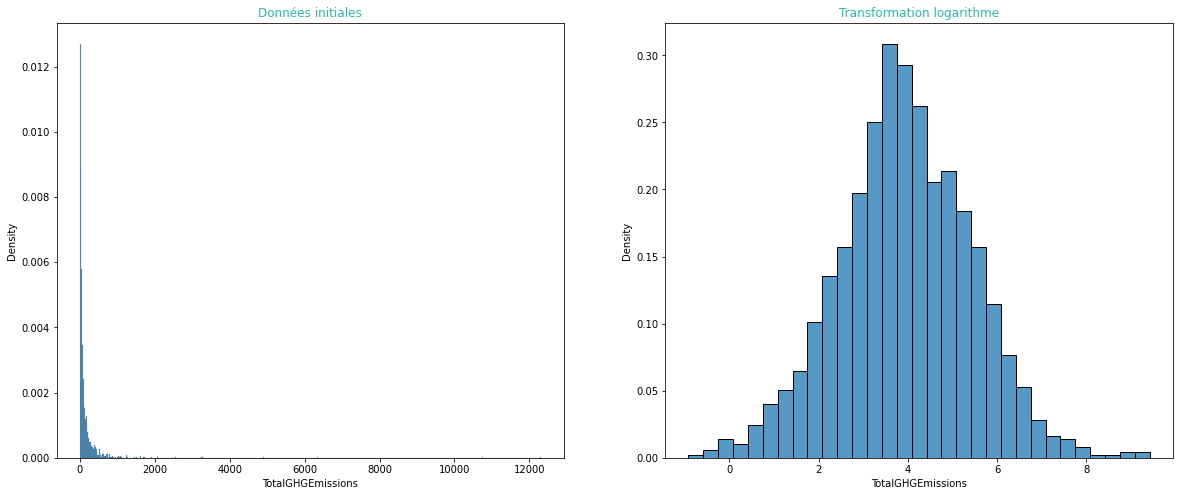

In [72]:
from sklearn.preprocessing import FunctionTransformer

logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_log = logtransformer.transform(Y)
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=Y, x='TotalGHGEmissions', stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='#2cb7b0')
sns.histplot(data=Y_log, x='TotalGHGEmissions', stat="density", ax=axes[1])
axes[1].set_title("Transformation logarithme", color='#2cb7b0')
plt.show()

Modèle baseline : Régression linéaire

### Création de Pipeline de transformation des variables : Scaling et One-hot encoding (pour les variables qualitatives).

---

In [73]:
# Séparation des variables numériques et des variables qualitatives
numerical_features  =  ['NumberofBuildings','NumberofFloors','PropertyGFATotal','ENERGYSTARScore','age_batiment','Ratio_parkingParSurface','pr_steam','pr_natural','pr_elec']
categorical_features  = ['PrimaryPropertyType','LargestPropertyUseType'] 

global  X_train, X_test, Y_train, Y_test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=35, shuffle=True)

# Scaling
numerical_pipeline = Pipeline(steps=[
      #('impute', SimpleImputer(strategy='mean')),
      ('scale', StandardScaler())   
  ])

#OneHotencoder
categorical_pipeline= Pipeline(steps=[
      #('impute', SimpleImputer(strategy='most_frequent')),
      ('one-hot',OneHotEncoder())
  ])


# Création d'un ColumnTransformer pour appliquer un pipeline pour chaque type de colonne
preprocessor = ColumnTransformer(transformers=[
      ('numerical_pipeline',numerical_pipeline,numerical_features),
      ('categorical_pipeline=',categorical_pipeline,categorical_features )
      ],
      remainder='passthrough',
      n_jobs=-1,
      )


### Modèle baseline  : DummyRegressor
---

In [74]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import  make_scorer

cv = KFold(n_splits=5, shuffle=True, random_state=45)

model_baseline= Pipeline(
    steps=[("preprocessor", preprocessor), ("DUM", TransformedTargetRegressor(regressor= DummyRegressor()  ,func=np.log1p, inverse_func=np.expm1))]
)

dummy_param_grid = [ {"DUM__regressor__strategy": ["mean"]} ]   

myscore = ('r2','neg_mean_absolute_error')
dummy_grid_search = GridSearchCV(estimator=model_baseline,
        param_grid=dummy_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error', n_jobs=-1,
        cv=cv,return_train_score=True) 

#cross_val_score(model_baseline, X_train, Y_train['TotalGHGEmissions'], cv=cv,scoring=r2)

In [75]:
dumy_model=dummy_grid_search.fit (X_train, Y_train['TotalGHGEmissions'])

Metrics de notre modèle baseline

In [76]:
y_test = Y_test['TotalGHGEmissions']
y_pred= dummy_grid_search.predict(X_test)
print("Metrics de notre modèle baseline \n")
print ( "R2 : " , round(r2_score (y_test, y_pred),2) ,  "| MAE :", round(mean_absolute_error (y_test, y_pred),2), ' | RMSE :', np.sqrt(round(mean_squared_error (y_test, y_pred),2) ))

Metrics de notre modèle baseline 

R2 :  -0.11 | MAE : 102.71  | RMSE : 220.75882768306232


Qualité prédictive de notre modèle baseline.


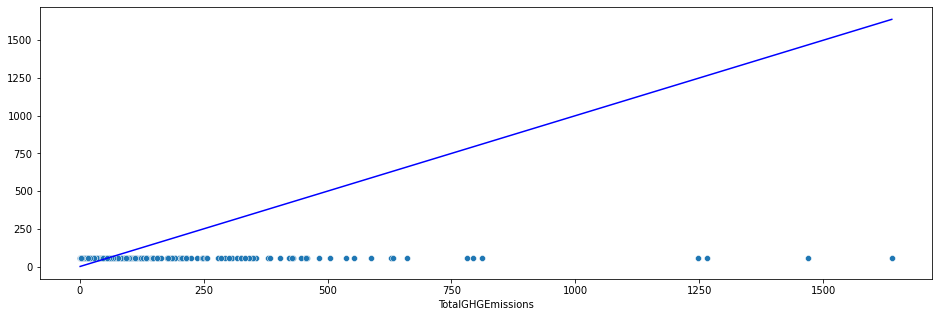

In [77]:
# traçage de y_test versus y_pred
# l'idéal c'est que tous les points doivent le plus possible être aliognés sur la droite.

plt.figure(figsize=(16,5))
p1 = max(max(y_test), max(y_pred))
p2 = min(min(y_test), min(y_pred))
plt.plot([p1, p2], [p1, p2], 'b-')
sns.scatterplot(x=y_test, y=y_pred)

### Pipeline de création des modèles à tester et GridSearch

---

### Code get feauture name

In [78]:
# Code copié à partir du site : https://bbakiu.medium.com/extracting-feature-names-from-the-columntransformer-f1bed520aeba
import warnings

from sklearn.pipeline import Pipeline

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    
    
    # Get columns and bin edges
    def pair_bin_edges_columns(bins_edges, columns):
        all_edge_column = []
        for index in range(len(columns)):
            bin_edge = bins_edges[index]
            column = columns[index]
            
            pair_bin_edge = []
            # match consecutive bin edges together
            for first, second in zip(bin_edge, bin_edge[1:]):
                pair_bin_edge.append((first, second))
            
            bin_edge_column = [column +": ["+ str(edge[0]) +", "+ str(edge[1])+")"  for edge in pair_bin_edge]
            all_edge_column.extend(bin_edge_column)
        return all_edge_column
    
    
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            
            # For transformers that create bins
            if hasattr(trans, 'bin_edges_'):
                bins_edges = trans.bin_edges_
                pairs_edges_columns = pair_bin_edges_columns(bins_edges, column)
            if column is None:
                return []
            else:
                return [name + "__" + f for f in pairs_edges_columns]
        return [name + "__" + f for f in trans.get_feature_names(column)]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    for name, trans, column, _ in l_transformers:
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [79]:
#feat_importances.plot(kind='barh(a'"')

### GridSearch pour les différents modèles

Pipeline, paramètre  et Gridsearch de tous les modèles à tester. J'ai en premier effectué un RandomisedSearch pour détecter les meilleurs hyperparamètre pour chaque modèle, puis j'ai effectué un GridSearch avec les paramètres trouvés avec le RandomisedSearch. Cela premet de réduire le temps d'execution de notre code vu qu'on peut être amené à l'excuter plusieurs fois.

In [80]:
#################             Régression linéaire multiple     ##########
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import RandomizedSearchCV
nb_split = 5
score = ['accuracy','neg_mean_absolute_error','neg_mean_squared_error']

pipe_lr = Pipeline(
    steps=[("preprocessor", preprocessor), ("LR", TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1) )]
)

myscore = ('r2','neg_mean_absolute_error','neg_mean_squared_error')

lr_param_grid = [ {"LR__regressor__fit_intercept": [True, False]}   ] 


lr_grid_search = GridSearchCV(estimator=pipe_lr,
        param_grid=lr_param_grid, refit='neg_mean_absolute_error',
        scoring=myscore, n_jobs=-1,
        cv=nb_split,return_train_score=True)


########################         Elastic Net           ######################

pipe_elastic = Pipeline(
    steps=[("preprocessor", preprocessor), ("ELN", TransformedTargetRegressor(regressor=ElasticNet() ,func=np.log, inverse_func=np.exp) )]
)
## Paramaètre du randomize search
"""elastic_param_grid = [     {"ELN__regressor__max_iter": [10, 100, 1000],
                            "ELN__regressor__alpha": np.logspace(-5, 5, num=10),  # alpha plus grand --- - 5 à 5 , augmenter la granularité
                             "ELN__regressor__l1_ratio": np.arange(0.0, 1.1, 0.1) } ]   """

elastic_param_grid ={'ELN__regressor__alpha': [0.9],
 'ELN__regressor__l1_ratio':[ 0.0 ],
 'ELN__regressor__max_iter': [100]}

elastic_grid_search = GridSearchCV(estimator=pipe_elastic,
        param_grid=elastic_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error', n_jobs=-1,
        cv=nb_split,return_train_score=True) 

########################         Linear SVR           ######################
pipe_lsvr =Pipeline(
    steps=[("preprocessor", preprocessor), ("LinearSVR", TransformedTargetRegressor(regressor=LinearSVR() ,func=np.log, inverse_func=np.exp) )]
)
lsvr_param_grid = [      {'LinearSVR__regressor__C' : np.logspace(-4, 0, 5),
                          'LinearSVR__regressor__epsilon' : [0, 0.01, 0.1, 0.5, 1, 2],
                         'LinearSVR__regressor__loss' : ["epsilon_insensitive","squared_epsilon_insensitive"],
                          'LinearSVR__regressor__max_iter': [10, 100, 1000]}   ] 


"""lsvr_param_grid ={'LinearSVR__regressor__C': [0.6],
 'LinearSVR__regressor__epsilon': [1],
 'LinearSVR__regressor__loss': ['epsilon_insensitive'],
 'LinearSVR__regressor__max_iter': [10]}"""

lsvr_grid_search = GridSearchCV(estimator=pipe_lsvr,
        param_grid=lsvr_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error', n_jobs=-1,
        cv=nb_split, return_train_score=True)


########################         Random Forest           ######################
pipe_rfr= Pipeline(
    steps=[("preprocessor", preprocessor), ("RandomForest", TransformedTargetRegressor(regressor=RandomForestRegressor() ,func=np.log, inverse_func=np.exp) )]
)

# Paramètre pour le Randomize search
"""rfr_param_grid = [ {'RandomForest__regressor__max_features' : ['sqrt', 'log2'],
                   'RandomForest__regressor__max_depth': [15, 25, 200],
                   'RandomForest__regressor__min_samples_split': [2, 7, 8],
                   'RandomForest__regressor__bootstrap' : [True, False],
                   'RandomForest__regressor__min_samples_leaf': [1,2,5]}"""

rfr_param_grid={'RandomForest__regressor__bootstrap': [False],
                'RandomForest__regressor__max_depth': [25,50],
                'RandomForest__regressor__max_features': ['sqrt'],
                'RandomForest__regressor__min_samples_leaf': [1],
                'RandomForest__regressor__min_samples_split': [2]}
                                                      
rfr_grid_search = GridSearchCV(estimator=pipe_rfr,
       param_grid=rfr_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error', n_jobs=-1,
        cv=nb_split, return_train_score=True)                                                  
                                                 
########################         ExtratreeRegressor          ######################


pipe_extra = Pipeline(
    steps=[("preprocessor", preprocessor), ("ExtraTree", TransformedTargetRegressor(regressor=ExtraTreesRegressor(random_state=0) ,func=np.log, inverse_func=np.exp) ) ] 
)

## Paramaètre du randomize search
"""  {'ExtraTree__regressor__n_estimators':[350,500],
         'ExtraTree__regressor__max_depth':[8,9,10],
         'ExtraTree__regressor__min_samples_split':[3,4,6],
         'ExtraTree__regressor__min_samples_leaf':[2,3,4],
         'ExtraTree__regressor__max_features':[0.95],
         'ExtraTree__regressor__min_impurity_decrease':[1e-5,1e-4,0]}  """

## Paramètre choisis  pour le gridsearch après le Randomize search
param_grid_mlp = {'ExtraTree__regressor__n_estimators': [350],
 'ExtraTree__regressor__min_samples_split':[ 3],
 'ExtraTree__regressor__min_samples_leaf': [2],
 'ExtraTree__regressor__min_impurity_decrease': [1e-05],
 'ExtraTree__regressor__max_features': [0.95],
 'ExtraTree__regressor__max_depth': [10]}




extraTree_grid_search = GridSearchCV(estimator=pipe_extra,
        param_grid =param_grid_mlp,
        scoring=myscore, refit='neg_mean_absolute_error', n_jobs=-1,
        cv=nb_split, return_train_score=True) 

########################         XgBoost Regressor          #####################
pipe_gb= Pipeline(
    steps=[("preprocessor", preprocessor), ("GB", TransformedTargetRegressor(regressor=GradientBoostingRegressor() ,func=np.log, inverse_func=np.exp) )]
)

# Paramètre du randomized Search
"""param_grid_GrBoostR = [{'GB__regressor__n_estimators': [350,500,700], 
                        'GB__regressor__max_depth': [5,6,7], 
                        'GB__regressor__min_samples_split': [2,3,4], 
                        'GB__regressor__learning_rate': [0.01,0.1], 
                        'GB__regressor__loss': ['ls'],
                       "GB__regressor__random_state" : [0]
                       }] """

param_grid_GrBoostR={'GB__regressor__random_state': [0],
                    'GB__regressor__n_estimators': [350],
                    'GB__regressor__min_samples_split': [3],
                    'GB__regressor__max_depth': [5],
                    'GB__regressor__loss': ['ls'],
                    'GB__regressor__learning_rate': [0.1]}

gb_grid_search =  GridSearchCV(estimator=pipe_gb,
         param_grid=param_grid_GrBoostR,
        scoring=myscore, refit='neg_mean_absolute_error', n_jobs=-1,
        cv=nb_split, return_train_score=True)   


Architecture de chaque modèle 

In [81]:
lr_grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('numerical_pipeline',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler())]),
                                                                         ['NumberofBuildings',
                                                                          'NumberofFloors',
                                                                          'PropertyGFATotal',
                                                                          'ENERGYSTARScore',
                                                                          'age_batiment',
                                                                          'Ratio_parkingParSurface',
                                                                          'pr_steam',
                                                                          'pr_natural',
                                                                          'pr_elec']),
                                                                        ('cat...
                                                                         ['PrimaryPropertyType',
                                                                          'LargestPropertyUseType'])])),
                                       ('LR',
                                        TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                                   inverse_func=<ufunc 'expm1'>,
                                                                   regressor=LinearRegression()))]),
             n_jobs=-1,
             param_grid=[{'LR__regressor__fit_intercept': [True, False]}],
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error',
                      'neg_mean_squared_error'))

### Entrainement des modèles et choix des meilleurs modèles après le GridSearch
---

In [82]:
global target
global R
global lr_grid_search_model , elastic_grid_search_model, lsvr_grid_search_model, rfr_grid_search_model , mlp_grid_search_model, gb_grid_search_model
target = ['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']


In [83]:
def train_model (model) :
  mymod = model.fit(X_train,Y_train['TotalGHGEmissions'])
  y_test = Y_test['TotalGHGEmissions']
  y_pred= mymod.predict(X_test)
  print ( "R2 : " , round(r2_score (y_test, y_pred),2) ,  "| MAE :", round(mean_absolute_error (y_test, y_pred),2), ' | RMSE :', round( np.sqrt(mean_squared_error (y_test, y_pred)),2))
  return mymod.best_params_


In [84]:
%%time
target_x =target[0]
lr_grid_search_model = lr_grid_search.fit(X_train,Y_train['TotalGHGEmissions'])
elastic_grid_search_model = elastic_grid_search.fit(X_train,Y_train['TotalGHGEmissions'])
lsvr_grid_search_model = lsvr_grid_search.fit(X_train,Y_train['TotalGHGEmissions'])
rfr_grid_search_model = rfr_grid_search.fit(X_train,Y_train['TotalGHGEmissions'])
mlp_grid_search_model = extraTree_grid_search.fit(X_train,Y_train['TotalGHGEmissions'])
gb_grid_search_model = gb_grid_search.fit(X_train,Y_train['TotalGHGEmissions'])


CPU times: user 5.97 s, sys: 90.5 ms, total: 6.06 s
Wall time: 36.6 s


In [85]:
modele ={ 'Linear Regression': lr_grid_search_model, 'Elastic Net' : elastic_grid_search_model , 'Linear SVR': lsvr_grid_search_model ,
         'RandomForest':rfr_grid_search_model, 'ExtraTree Regressor':mlp_grid_search_model,'GradientBoost' : gb_grid_search_model}

###  Choix du meilleur modèle pour la variable target TotalGHGEmissions 
---

Metrics de chaque modèle sur la cross validation du Gridsearch.

In [86]:
a=pd.DataFrame(lr_grid_search_model.cv_results_)[[	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_neg_mean_squared_error','mean_test_r2'	,'std_train_neg_mean_absolute_error','params', ]].head(1)
b=pd.DataFrame(elastic_grid_search_model.cv_results_)[[	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_neg_mean_squared_error','mean_test_r2'	,'std_train_neg_mean_absolute_error','params',]].head(1)
c=pd.DataFrame(lsvr_grid_search_model.cv_results_)[['mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_neg_mean_squared_error','mean_test_r2'	,'std_train_neg_mean_absolute_error','params',	]].head(1)
d=pd.DataFrame(rfr_grid_search_model.cv_results_)[[	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_neg_mean_squared_error','mean_test_r2'	,'std_train_neg_mean_absolute_error','params',]].head(1)
e=pd.DataFrame(mlp_grid_search_model.cv_results_)[[	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_neg_mean_squared_error','mean_test_r2'	,'std_train_neg_mean_absolute_error','params',]].head(1)
f=pd.DataFrame(gb_grid_search_model.cv_results_)[[	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_neg_mean_squared_error','mean_test_r2'	,'std_train_neg_mean_absolute_error','params',]].head(1)

R=pd.concat([a, b,c,d,e,f])
R["Modèles"] = ['LinearRegression', 'ElasticNet', 'Linear SVR', 'RandomForest', 'Extratree Regressor', 'GradientBoost']

cols =R.columns.tolist()
cols = cols[-1:] + cols[:-1]
R= R[cols] 
R.rename(columns={'mean_fit_time' :'fit time', 'mean_test_neg_mean_absolute_error' : 'MAE (moyen)','mean_test_neg_mean_squared_error' : 'MSE (moyen)','mean_test_r2' :'R2 (moyen)'	,'std_train_neg_mean_absolute_error': 'std_MAE'}, inplace=True)
R['MAE (moyen)'] = -R['MAE (moyen)']
R['MSE (moyen)'] = -R['MSE (moyen)']
#R['RMSE'] = -R['RMSE']
R

,Modèles,fit time,MAE (moyen),MSE (moyen),R2 (moyen),std_MAE,params
0,LinearRegression,0.040679,358.736771,6.038515e+07,-95.299162,75.492529,{'LR__regressor__fit_intercept': True}
0,ElasticNet,0.033274,131.188903,2.986782e+05,-0.401125,5.006879,"{'ELN__regressor__alpha': 0.9, 'ELN__regressor..."
0,Linear SVR,0.018322,175.550217,4.380052e+05,-0.132789,5.752539,"{'LinearSVR__regressor__C': 0.0001, 'LinearSVR..."
0,RandomForest,0.539696,84.223874,1.308057e+05,0.604828,0.192437,"{'RandomForest__regressor__bootstrap': False, ..."
0,Extratree Regressor,1.967041,82.772055,1.241124e+05,0.624078,1.769103,"{'ExtraTree__regressor__max_depth': 10, 'Extra..."
0,GradientBoost,1.163265,69.930513,6.800470e+04,0.743358,0.782055,"{'GB__regressor__learning_rate': 0.1, 'GB__reg..."


Le modèle qui offre de meilleurs performances sur la Cross-Validation du grid Search est le GradientBoost. Il a un MAE et MSE plus petit et R2 plus important que les autres modèles.

### Qualité de prediction du meilleur modèle choisi après le GridSearch : le modèle gradientBoost

---

In [87]:
dict_train={}

for m in modele.keys() :
  y_pred =modele[m].best_estimator_.predict(X_train)
  dict_train[m] = [round(mean_squared_error(Y_train['TotalGHGEmissions'],y_pred),3) , round(np.sqrt(mean_squared_error(Y_train['TotalGHGEmissions'],y_pred)) ,2), round((mean_absolute_error(Y_train['TotalGHGEmissions'],y_pred)),2),round((r2_score(Y_train['TotalGHGEmissions'],y_pred)),2)  ]


dict_test={}

for m in modele.keys() :
  y_pred =modele[m].best_estimator_.predict(X_test)
  dict_test[m] = [ round(mean_squared_error(Y_test['TotalGHGEmissions'],y_pred),3) ,round(np.sqrt(mean_squared_error(Y_test['TotalGHGEmissions'],y_pred)) ,2), round((mean_absolute_error(Y_test['TotalGHGEmissions'],y_pred)),2),round((r2_score(Y_test['TotalGHGEmissions'],y_pred)),2) ]


### Qualité de prédiction de chaque modèle du modèle GradientBoost sur le test et le train set.
----



In [88]:
#Prédiction sur le train set
print ("                           Metrics sur le Train set")
metrics=pd.DataFrame(dict_train)
metrics.index = (["MSE","RMSE","MAE","R2"])
display(metrics.T)
print("\n")

# Prédiction sur le test set
print ("                           Metrics sur le Test set")
metrics=pd.DataFrame(dict_test)
metrics.index = (["MSE","RMSE","MAE","R2"])
display(metrics.T)

#= 8, 45(good) , 90  - 22  et 35 (very good), 0 (bon MAE pour gradient boost) , 80 (=comme le 8), 65 (gentil avec svr et elastic)

                           Metrics sur le Train set


,MSE,RMSE,MAE,R2
Linear Regression,2.953098e+07,5434.24,269.99,-71.56
Elastic Net,2.643180e+05,514.12,126.54,0.35
Linear SVR,2.724566e+05,521.97,131.94,0.33
RandomForest,5.698000e+00,2.39,0.28,1.00
ExtraTree Regressor,2.390609e+04,154.62,45.22,0.94
GradientBoost,6.635760e+02,25.76,9.73,1.00




                           Metrics sur le Test set


,MSE,RMSE,MAE,R2
Linear Regression,19324.040,139.01,63.04,0.56
Elastic Net,37459.760,193.55,85.61,0.15
Linear SVR,35682.754,188.90,85.77,0.19
RandomForest,19531.043,139.75,56.82,0.55
ExtraTree Regressor,13306.783,115.36,51.23,0.70
GradientBoost,8308.751,91.15,44.29,0.81


Avec les résultats ci-dessus, on voit  que le modèle GradientBoost offre le meilleur score **MAE**  (environ 44) et un meilleur $R^2$ (~0.81) . On rentiendra ce modèle pour la modélisation de la 
variable **TotalGHGEmissions** est donc le modèle GradientBoost.

### Temps d'entrainement de chaque modèles
---

In [89]:
import plotly.graph_objects as go
fig = go.Figure([ go.Bar(name='temps entrainement',x=R['Modèles'], y=R['fit time'])])
fig.update_layout(barmode='group',autosize=False, width=700, height=400)

fig.show()

Observons les scores obtenus sur les différents splits de la Cross-validation du GridSearch.

### Code pour tracer les performances sur train et le test set de la cross validation du grid search

In [90]:
import plotly.express as px
def trace_mae(mymodel) :
  t1=pd.DataFrame(mymodel.cv_results_)[["split0_train_neg_mean_absolute_error",	"split1_train_neg_mean_absolute_error","split2_train_neg_mean_absolute_error",	"split3_train_neg_mean_absolute_error",	"split4_train_neg_mean_absolute_error"	,"rank_test_neg_mean_absolute_error"]].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
  t1=pd.DataFrame(mymodel.cv_results_)[["split0_train_neg_mean_absolute_error",	"split1_train_neg_mean_absolute_error","split2_train_neg_mean_absolute_error",	"split3_train_neg_mean_absolute_error","split4_train_neg_mean_absolute_error"]]
  t2= pd.DataFrame(mymodel.cv_results_)[["split0_test_neg_mean_absolute_error",	"split1_test_neg_mean_absolute_error","split2_test_neg_mean_absolute_error",	"split3_test_neg_mean_absolute_error",	"split4_test_neg_mean_absolute_error"	,"rank_test_neg_mean_absolute_error"]].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
  t2= pd.DataFrame(mymodel.cv_results_)[["split0_test_neg_mean_absolute_error",	"split1_test_neg_mean_absolute_error","split2_test_neg_mean_absolute_error",	"split3_test_neg_mean_absolute_error",	"split4_test_neg_mean_absolute_error"]]

  df1_transposed = t1.T
  df1_transposed 
  df2_transposed = t2.T
  final=pd.concat ([df1_transposed,df2_transposed ])
  final["Split_cross validation"] = list(range(nb_split)) + list(range(nb_split))
  final.rename(columns={0: "MAE"}, inplace=True)
  final=final.reset_index()
  final ["color"] = np.where( final["index"].str.contains("test"), "test", "train")
  final

  fig = px.line( final, x='Split_cross validation',y='MAE', color='color', symbol="color",width=800, height=400)
  fig.show()

def trace_r2(mymodel) :
    t1=pd.DataFrame(mymodel.cv_results_)[["split0_train_r2",	"split1_train_r2","split2_train_r2",	"split3_train_r2",	"split4_train_r2"	,"rank_test_neg_mean_absolute_error"]].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
    t1=pd.DataFrame(mymodel.cv_results_)[["split0_train_r2",	"split1_train_r2","split2_train_r2",	"split3_train_r2","split4_train_r2"]]
    t2= pd.DataFrame(mymodel.cv_results_)[["split0_test_r2",	"split1_test_r2","split2_test_r2",	"split3_test_r2",	"split4_test_r2"	,"rank_test_neg_mean_absolute_error"]].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
    t2= pd.DataFrame(mymodel.cv_results_)[["split0_test_r2",	"split1_test_r2","split2_test_r2",	"split3_test_r2",	"split4_test_r2"]]

    df1_transposed = t1.T
    df1_transposed 
    df2_transposed = t2.T
    final=pd.concat ([df1_transposed,df2_transposed ])
    final["Split_cross validation"] = list(range(nb_split)) + list(range(nb_split))
    final.rename(columns={0: "R2"}, inplace=True)
    final=final.reset_index()
    final ["color"] = np.where( final["index"].str.contains("test"), "test", "train")
    final

    fig = px.line( final, x='Split_cross validation',y='R2', color='color', symbol="color",width=800, height=400)
    fig.show()



### Performance de notre modèle selectionné dans le train et le test set de  chaque split de la crossvalidation du Gridsearch

In [91]:
trace_mae(mlp_grid_search_model)
trace_r2(mlp_grid_search_model)

On voit bien ici que la performance du modèle GradientBoost s'entraîne bien sur les différents split de la cross-validation.

### Feature importance du meilleur modèle
---

In [92]:
#Poids de chaque feature dans le modèle
feature_importance_value1=gb_grid_search_model.best_estimator_.named_steps["GB"].regressor_.feature_importances_ 

#Noms de features utilisés dans le modèle
feature_names = get_feature_names(gb_grid_search_model.best_estimator_.named_steps['preprocessor'])

#Dataframe regroupant les features et leur poids
feat_importances1= pd.Series(feature_importance_value1 , index=feature_names)

In [93]:
#Création et transposition de la dataframe feature importance
feat_importances1= pd.DataFrame(feat_importances1).transpose()

#Agrégation des features par appartenance à une catégorie
feat_importances1['PrimaryPropertyType']= feat_importances1[list(feat_importances1.filter(regex='one-hot__x0'))].sum(axis=1)
feat_importances1['LargestPropertyUseType']= feat_importances1[list(feat_importances1.filter(regex='one-hot__x1'))].sum(axis=1)
#feat_importances1["BuildingType"]= feat_importances1[list(feat_importances1.filter(regex='one-hot__x2'))].sum(axis=1)

# Colonnes à supprimer 
unwanted = feat_importances1.columns[feat_importances1.columns.str.startswith('one-hot__x')]
feat_importances1.drop(unwanted, axis=1, inplace=True)

#On ramène la dataFrame à sa forme initiale
feat_importances1= pd.DataFrame(feat_importances1).transpose()

#On renomme et reformate les valeurs de la colonne feature
df2=feat_importances1.reset_index().rename(columns={"index": "features", 0: "poids"})
df2['features']=df2['features'].str.replace('numerical_pipeline__','')


### Tracé feature importance

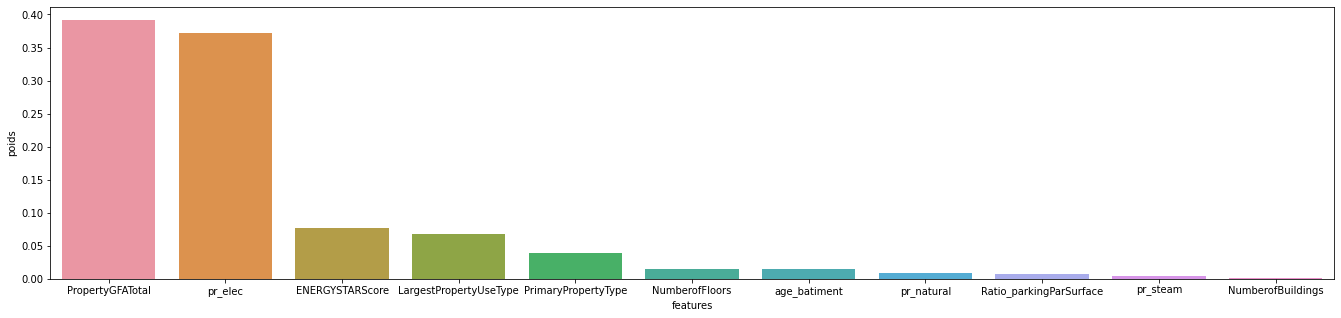

In [94]:
#On trace le graphique du feature importance 
plt.figure(figsize=(23,5))
sns.barplot(x='features', y='poids', data=df2.sort_values(by='poids', ascending=False))

On voit sur ce graphique les features qui ont plus d'impact sur notre modèle.

A partir de ce graphique, nous pouvons décider de supprimer les features qui ont très peu d'importance. On obtiendra un modèle plus simple et sans doute avec une moindre variance. 

On peut  aussi regarder sur quelles données le meilleurs modèle fait de grosses erreur, et essayer de comprendre pourquoi: des donnée atypique ? manque-t-il un feature pour les capter ?  Données abbérentes ? faut-il les supprimmer ? 

### Valeurs prédites vs Valeurs réelles de notre meilleur modèle.
---

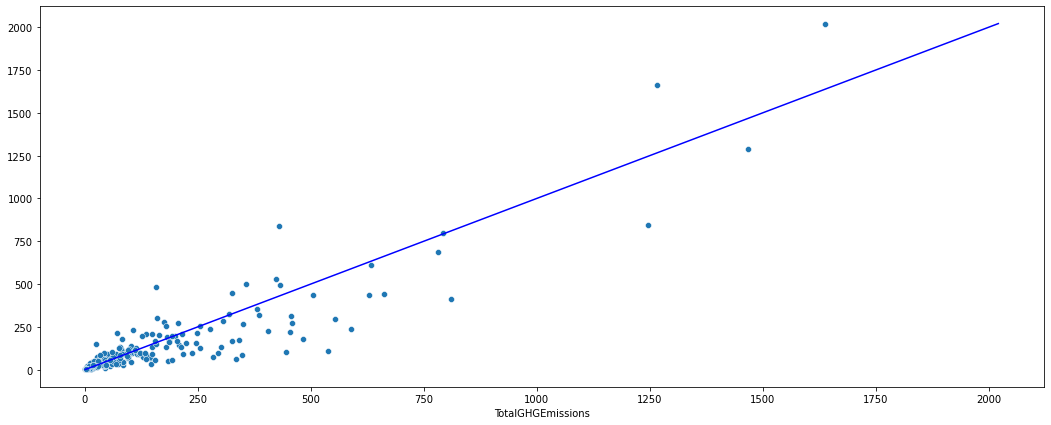

In [95]:
y_pred =gb_grid_search_model.best_estimator_.predict(X_test)
plt.figure(figsize=(18,7))
y_test=Y_test[target[0]]
# traçage de y_test versus y_pred
# l'idéal aurait dû être une ligne droite
p1 = max(max(y_test), max(y_pred))
p2 = min(min(y_test), min(y_pred))
plt.plot([p1, p2], [p1, p2], 'b-')
sns.scatterplot(x=y_test, y=y_pred)

Les points s'alignent relativement bien sur la droite. La qualitéa de prédictions de notre modèle n'est pas mal.

# <ins>Importance de EnergysStarScore pour la variable target TOtalGHGEmissions</ins>

Nous allons voir si EnergyStar a un impact sur les modèles 

On enlève la variable ENERGYSTARScore

###Run du code

In [96]:
# Création de piepeline pour les features numériques et catégoriels   ----  'SiteEnergyUse(kBtu)','TotalGHGEmissions',
numerical_features1  =  ['NumberofBuildings','NumberofFloors','PropertyGFATotal','age_batiment','Ratio_parkingParSurface','pr_steam','pr_natural','pr_elec']
categorical_features1  = ['PrimaryPropertyType','LargestPropertyUseType'] #'LargestPropertyUseType',"BuildingType"



numerical_pipeline1 = Pipeline(steps=[
      #('impute', SimpleImputer(strategy='mean')),
      ('scale', StandardScaler())   
  ])
categorical_pipeline1= Pipeline(steps=[
      #('impute', SimpleImputer(strategy='most_frequent')),
      ('one-hot',OneHotEncoder())
  ])

  # Création d'un ColumnTransformer pour appliquer un pipeline pour chaque type de colonne

preprocessor = ColumnTransformer(transformers=[
      ('numerical_pipeline1',numerical_pipeline1,numerical_features1),
      ('categorical_pipeline1=',categorical_pipeline1,categorical_features1 )
      ],
      remainder='passthrough',
      n_jobs=-1,
      )

#X = data_model.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions'], axis=1)
#Y = data_model[['SiteEnergyUse(kBtu)','TotalGHGEmissions']]

#Régression linéaire multiple
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import RandomizedSearchCV
nb_split = 5
score = ['accuracy','neg_mean_absolute_error']

pipe_lr = Pipeline(
    steps=[("preprocessor", preprocessor), ("LR", TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1) )]
)

myscore = ('r2','neg_mean_absolute_error')

lr_param_grid = [ {"LR__regressor__fit_intercept": [True, False]}   ] 


lr_grid_search1 = GridSearchCV(estimator=pipe_lr,
        param_grid=lr_param_grid, refit='neg_mean_absolute_error',
        scoring=myscore, n_jobs=-1,
        cv=nb_split,return_train_score=True)


#Elastic Net

pipe_elastic = Pipeline(
    steps=[("preprocessor", preprocessor), ("ELN", TransformedTargetRegressor(regressor=ElasticNet() ,func=np.log, inverse_func=np.exp) )]
)
## Paramaètre du randomize search
"""elastic_param_grid = [     {"ELN__regressor__max_iter": [10, 100, 1000],
                            "ELN__regressor__alpha": np.logspace(-5, 5, num=10),  # alpha plus grand --- - 5 à 5 , augmenter la granularité
                             "ELN__regressor__l1_ratio": np.arange(0.0, 1.1, 0.1) } ]   """

elastic_param_grid ={'ELN__regressor__alpha': [0.0],
 'ELN__regressor__l1_ratio':[ 0.0 ],
 'ELN__regressor__max_iter': [100]}

elastic_grid_search1 = GridSearchCV(estimator=pipe_elastic,
        param_grid=elastic_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error', n_jobs=-1,
        cv=nb_split,return_train_score=True) 

# Linear SVM
pipe_lsvr =Pipeline(
    steps=[("preprocessor", preprocessor), ("LSVR", TransformedTargetRegressor(regressor=LinearSVR() ,func=np.log, inverse_func=np.exp) )]
)

"""lsvr_param_grid = [      {'LSVR__regressor__C' : np.logspace(-4, 0, 5),
                          'LSVR__regressor__epsilon' : [0, 0.01, 0.1, 0.5, 1, 2],
                         'LSVR__regressor__loss' : ["epsilon_insensitive","squared_epsilon_insensitive"],
                          'LSVR__regressor__max_iter': [10, 100, 1000]}   ]  """


lsvr_param_grid ={'LSVR__regressor__C': [0.01],
 'LSVR__regressor__epsilon': [1],
 'LSVR__regressor__loss': ['epsilon_insensitive'],
 'LSVR__regressor__max_iter': [10]}

lsvr_grid_search1 = GridSearchCV(estimator=pipe_lsvr,
        param_grid=lsvr_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error', n_jobs=-1,
        cv=nb_split, return_train_score=True)


# Random Forest
pipe_rfr= Pipeline(
    steps=[("preprocessor", preprocessor), ("RFR", TransformedTargetRegressor(regressor=RandomForestRegressor() ,func=np.log, inverse_func=np.exp) )]
)

# Paramètre pour le Randomize search
"""rfr_param_grid = [ {'RFR__regressor__max_features' : ['sqrt', 'log2'],
                   'RFR__regressor__max_depth': [15, 25, 200],
                   'RFR__regressor__min_samples_split': [2, 7, 8],
                   'RFR__regressor__bootstrap' : [True, False],
                   'RFR__regressor__min_samples_leaf': [1,2,5]}"""

rfr_param_grid={'RFR__regressor__bootstrap': [False],
                'RFR__regressor__max_depth': [25,50],
                'RFR__regressor__max_features': ['sqrt'],
                'RFR__regressor__min_samples_leaf': [1],
                'RFR__regressor__min_samples_split': [2]}
                                                      
rfr_grid_search1 = GridSearchCV(estimator=pipe_rfr,
       param_grid=rfr_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error', n_jobs=-1,
        cv=nb_split, return_train_score=True)                                                  
                                                 
# Rajouter une métrique pour GridSearch
# Xgboost Regressor


pipe_extra = Pipeline(
    steps=[("preprocessor", preprocessor), ("MLP", TransformedTargetRegressor(regressor=ExtraTreesRegressor(random_state=0) ,func=np.log, inverse_func=np.exp) ) ] 
)

## Paramaètre du randomize search
"""  {'MLP__regressor__n_estimators':[350,500],
         'MLP__regressor__max_depth':[8,9,10],
         'MLP__regressor__min_samples_split':[3,4,6],
         'MLP__regressor__min_samples_leaf':[2,3,4],
         'MLP__regressor__max_features':[0.95],
         'MLP__regressor__min_impurity_decrease':[1e-5,1e-4,0]}  """

## Paramètre choisis  pour le gridsearch après le Randomize search
param_grid_mlp = {'MLP__regressor__n_estimators': [350],
 'MLP__regressor__min_samples_split':[ 3],
 'MLP__regressor__min_samples_leaf': [2],
 'MLP__regressor__min_impurity_decrease': [1e-05],
 'MLP__regressor__max_features': [0.95],
 'MLP__regressor__max_depth': [10]}




extraTree_grid_search1 = GridSearchCV(estimator=pipe_extra,
        param_grid =param_grid_mlp,
        scoring=myscore, refit='neg_mean_absolute_error', n_jobs=-1,
        cv=nb_split, return_train_score=True) 

# Gradient boost
pipe_gb= Pipeline(
    steps=[("preprocessor", preprocessor), ("GB", TransformedTargetRegressor(regressor=GradientBoostingRegressor() ,func=np.log, inverse_func=np.exp) )]
)

# Paramètre du randomized Search
"""param_grid_GrBoostR = [{'GB__regressor__n_estimators': [350,500,700], 
                        'GB__regressor__max_depth': [5,6,7], 
                        'GB__regressor__min_samples_split': [2,3,4], 
                        'GB__regressor__learning_rate': [0.01,0.1], 
                        'GB__regressor__loss': ['ls'],
                       "GB__regressor__random_state" : [0]
                       }] """

param_grid_GrBoostR={'GB__regressor__random_state': [0],
                    'GB__regressor__n_estimators': [350],
                    'GB__regressor__min_samples_split': [3],
                    'GB__regressor__max_depth': [5],
                    'GB__regressor__loss': ['ls'],
                    'GB__regressor__learning_rate': [0.1]}

gb_grid_search1 =  GridSearchCV(estimator=pipe_gb,
         param_grid=param_grid_GrBoostR,
        scoring=myscore, refit='neg_mean_absolute_error', n_jobs=-1,
        cv=nb_split, return_train_score=True)   





import warnings
warnings.filterwarnings('ignore')



target = ['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']

global R1, y_test_predict1,lr_grid_search_model1 ,elastic_grid_search_model1,lsvr_grid_search_model1 , rfr_grid_search_model1



lr_grid_search_model1 = lr_grid_search1.fit(X_train,Y_train['TotalGHGEmissions'])
elastic_grid_search_model1 = elastic_grid_search1.fit(X_train,Y_train['TotalGHGEmissions'])
lsvr_grid_search_model1 = lsvr_grid_search1.fit(X_train,Y_train['TotalGHGEmissions'])
rfr_grid_search_model1 = rfr_grid_search1.fit(X_train,Y_train['TotalGHGEmissions'])
extraTree_grid_search_model1 = extraTree_grid_search1.fit(X_train,Y_train['TotalGHGEmissions'])
gb_grid_search_model1 = gb_grid_search1.fit(X_train,Y_train['TotalGHGEmissions'])


### Impact de EnergyStarUse sur TotalGHGEmissions
---

In [97]:
#Prédiction sans energyStarScore
y_test_predict1 = gb_grid_search_model1.predict(X_test)

v_avec =  [round((r2_score(Y_test['TotalGHGEmissions'],y_pred)),3), round((mean_absolute_error(Y_test['TotalGHGEmissions'],y_pred)),3)]
v_sans=[round((r2_score(Y_test['TotalGHGEmissions'],y_test_predict1)),3), round((mean_absolute_error(Y_test['TotalGHGEmissions'],y_test_predict1)),3)]

pd.DataFrame({ "Metrics": ["R2", "MAE"], "Modèle avec EnergyStarScore" : v_avec, "Modèle sans EnergyStarScore" : v_sans })


,Metrics,Modèle avec EnergyStarScore,Modèle sans EnergyStarScore
0,R2,0.811,0.812
1,MAE,44.292,43.746


Conclusion : L'energyStar Score n'a pas trop impact sur la qualité du modèle.

# ANNEXE : Dans cette annexe on analyse en profondeur les raisons pour lesquels nos modèles linéaires (linerRegression, Elastic Net, LinearSVR) n'offrent pas de bonnes performances. Vous trouverez à la fin l'explication de chaque modèle utilisé.

Création du dataset pour une regression avec Statsmodels.

In [98]:
%matplotlib inline
from scipy import stats
import statsmodels.api as sm
from sklearn import linear_model

In [99]:
data_for_lr =data_model[['TotalGHGEmissions','NumberofBuildings','NumberofFloors','PropertyGFATotal','age_batiment','Ratio_parkingParSurface','pr_steam','pr_natural','pr_elec','PrimaryPropertyType','LargestPropertyUseType']]
data_for_lr0 =data_for_lr[['TotalGHGEmissions','NumberofBuildings','NumberofFloors','PropertyGFATotal','age_batiment','Ratio_parkingParSurface','pr_steam','pr_natural']]

In [100]:
dummies = pd.get_dummies(data_for_lr[['PrimaryPropertyType']])   # On n'inclut pas 'LargestPropertyUseType' dans le modèle car cette variable n'apporte aucune information pertinente
data_for_lr1= pd.concat([data_for_lr0, dummies], axis=1)
data_for_lr1.head()

,TotalGHGEmissions,NumberofBuildings,NumberofFloors,PropertyGFATotal,age_batiment,Ratio_parkingParSurface,pr_steam,pr_natural,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Hospital,...,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility
0,249.98,1.0,12,88434,89,0.000,0.277302,0.176638,0,0,...,0,0,0,0,0,0,0,0,0,0
1,295.86,1.0,11,103566,20,14.545,0.000000,0.613391,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2089.28,1.0,41,956110,47,20.575,0.297113,0.020579,0,0,...,0,0,0,0,0,0,0,0,0,0
3,286.43,1.0,10,61320,90,0.000,0.325913,0.266567,0,0,...,0,0,0,0,0,0,0,0,0,0
4,505.01,1.0,18,175580,36,35.312,0.000000,0.621198,0,0,...,0,0,0,0,0,0,0,0,0,0


Création du modèle linéaire et analyse statistique pour voir si modèle de regression linéaire multiple est pertinent pour nos données.


In [101]:
mydata= data_for_lr1
X = mydata.loc[:, mydata.columns != 'TotalGHGEmissions']
#X = sm.add_constant(X) # une autre façons d'ajouter une constante
y = mydata['TotalGHGEmissions']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      TotalGHGEmissions   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     127.5
Date:                Sat, 11 Feb 2023   Prob (F-statistic):               0.00
Time:                        03:09:03   Log-Likelihood:                -10687.
No. Observations:                1487   AIC:                         2.143e+04
Df Residuals:                    1460   BIC:                         2.157e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

Les mauvaises performances du modèle de Regression Linéaire peuvent être attribuées au fait ques les residus (erreurs de prédictions) ne suivent pas une loi normale (d'après le test de Jacques Bera $Prob(JB)<0.05$) et sont pas parfaitement décoréllées($Durbin-Watson = 1.962$). Pour avoir une explication détaillée des tests de  Jacques Bera et Durbin Watson, voir bas de page.

Cepedant l'utilisation d'un modèle linéaire pour la modélisation ne manque de pertinence car ($Prob (F-statistic) < 0.05$)

Création du modèle linéaire et analyse statistique pour voir si modèle **elastic Net** est pertinent pour nos données.

In [102]:
model = sm.OLS(y, X)
results = model.fit_regularized(method='elastic_net', alpha=0.1, L1_wt=1.0,refit=True)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      TotalGHGEmissions   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     132.4
Date:                Sat, 11 Feb 2023   Prob (F-statistic):               0.00
Time:                        03:09:04   Log-Likelihood:                -10688.
No. Observations:                1487   AIC:                         2.143e+04
Df Residuals:                    1462   BIC:                         2.157e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

Les mauvaises performances du modèle Elastic Net peuvent être attribuées au fait ques les residus (erreurs de prédictions) ne suivent pas une loi normale (d'après le test de Jacques Bera $Prob(JB)<0.05$) et sont pas parfaitement décoréllées ($Durbin-Watson = 1.962$). Pour avoir une explication détaillée des tests de  Jacques Bera et Durbin Watson, voir bas de page.
Cepedant l'utilisation d'un modèle linéaire pour la modélisation ne manque de pertinence car ($Prob (F-statistic) < 0.05$)

En gros dans le cas où nous sommes le modèle (de régression) ne peut pas expliquer toutes les tendances de l'ensemble de données. Cela impacte la robustesse du modèle.


###  Test de Jacques Bera 

Un test de Jarque-Bera utilise les hypothèses nulles et alternatives suivantes :

L'hypothèse nulle **H0** : Les résidus sont normalement distribués.

L'hypothèse alternative **H1**: Les résidus ne sont pas distribués normalement.

Si la p-value (Prob(JB)) < 0.05  alors l'hypothèse nulle est rejetée.

Si p-value (Prob(JB)) > 0.05 ; alors nous échouons à rejeter l'hypothèse nulle.

### Test de Durbin watson

Durbin-Watson pour tester l'autocorrélation dans les résidus

Une méthode courante de test d'autocorrélation est le test de Durbin-Watson.

Recherchez la statistique Durbin – Watson (DW). Elle doit être comprise entre 0 et 4.



1.   Si DW = 2, ou proche de celui-ci, n'implique aucune autocorrélation
2.   L0 < DW < 2 implique une autocorrélation positive
3.   tandis que 2 < DW < 4 indique une autocorrélation négative





# Explication des modèles

##  <ins> I. Les modèles linéaires </ins>

1.<ins>**Regression linéaire**

Prenons des données, $n$ points en $p$
 dimensions, représentés par la matrice $ X∈\mathbb{R}^{n×p}$, avec leurs étiquettes à valeurs réelles, représentées  par un vecteur $y∈\mathbb{R}^{n}$
.

Le but de la régression linéaire est de trouver une fonction linéaire $f:\mathbb{R}^p→\mathbb{R}$
 qui permette de prédire l'étiquette $y^{(i)}$
 du i-ème point à partir du vecteur  $x^{(i)}$
. Autrement dit,  $f(x)$
 peut s'écrire sous la forme  $β_0+β_1x_1+β_2x_2+⋯+β_px_p$.
 

Comment trouver les valeurs des coefficients  $β_0,β_1,…,β_p$
 ?

2.<ins>**Elastic Net**

L'algorithme Elastic Net est un algorithme de régression linéaire combinant la régularisation $L_1$ (pénalité de la norme $L_1$) et $L_2$ (pénalité de la norme $L_2$). Il a été développé pour résoudre les problèmes de sélection de modèle en régression linéaire, où certaines variables peuvent être considérées comme peu importantes ou peu pertinentes pour expliquer la variable dépendante.

La fonction de coût pour l'algorithme Elastic Net peut être définie comme suit :

$J(\beta) = \frac{1}{2  n}  ||y - X  \beta||^2_2 + \lambda (\alpha  ||\beta||_1 + \frac{(1 - \alpha)}{2}  ||\beta||^2_2)$

Où :

$y$ est la variable dépendante

$X$ est la matrice de variables indépendantes

$\beta$ est le vecteur de coefficients de régression

$n$ est le nombre d'observations dans les données

$\alpha$ est un paramètre de régularisation contrôlant la force de la régularisation
$\lambda$ est un autre paramètre de régularisation contrôlant le mélange entre la régularisation $L_1$ et $L_2$

$||.||_1$ est la norme $L_1$ (somme absolue des éléments)

$||.||_2$ est la norme $L_2$ (somme des carrés des éléments)

*En résumé, l'algorithme Elastic Net optimise la fonction de coût en ajustant les coefficients beta de manière à minimiser la somme de la différence entre les valeurs prédites et observées (première partie de la fonction de coût) et la régularisation (deuxième partie de la fonction de coût). La régularisation $L_1$ **aide à sélectionner les variables les plus pertinentes en réduisant les coefficients des variables considérées comme peu importantes à zéro**, tandis que la régularisation **$L_2$ aide à limiter la complexité du modèle en pénalisant les coefficients de toutes les variables**.*





3.<ins>**Linear SVR**

L'algorithme de régression support vector machine (SVM) linéaire est un algorithme de modélisation de données qui peut être utilisé pour la régression et la classification. Il est basé sur le concept de maximiser la marge entre les données d'entraînement, c'est-à-dire la distance minimale entre les données d'entraînement et le modèle.

Dans le cas de la régression SVM linéaire, le but est de trouver un hyperplan séparant les données en deux classes, qui minimise l'erreur quadratique moyenne. L'hyperplan est défini par une équation de la forme:

$$ w_1 x_1 + w_2 x_2 + \cdots + w_n x_n + b = 0 $$

où $x_1, x_2, ..., x_n$ sont les caractéristiques d'une observation, $w_1, w_2, ..., w_n$ sont les coefficients associés à chaque caractéristique et $b$ est un terme constant.

La régression SVM linéaire se concentre sur la minimisation de l'erreur quadratique moyenne sous contrainte, où la contrainte est la marge maximale entre les données d'entraînement et l'hyperplan. Cela peut être formulé comme un problème d'optimisation sous contrainte:

$$ \min_{w, b} \frac{1}{N} \sum_{i=1}^{N} (y_i - (w^T x_i + b))^2 $$

$$ y_i (w^T x_i + b) \geq 1, ; i = 1, 2, ..., N $$

où $y_i$ est la cible associée à l'observation $x_i$

$N$ est le nombre d'observations dans les données d'entraînement

$w^T$ est le vecteur transposé de $w$ et le produit scalaire $w^T x_i$ est la projection de $x_i$ sur $w$.

Le problème peut être résolu en utilisant une méthode d'optimisation quadratique qui minimise la fonction objective en prenant en compte les contraintes. Une fois que les coefficients $w$ et $b$ sont trouvés, ils peuvent être utilisés pour faire des prédictions sur des observations inconnues en utilisant l'équation de l'hyperplan.










## <ins>II. Les modèles ensemblistes </ins>

### a) Les aglorithme bagging 

Le Bagging (Bootstrapped Aggregation) est un algorithme d'ensemble dans le domaine de l'apprentissage automatique. Il permet de réduire la variance d'un modèle en entraînant plusieurs modèles de base sur des sous-échantillons aléatoires du jeu de données d'entraînement. Les prédictions des modèles de base sont ensuite combinées pour obtenir une prédiction finale.

L'idée sous-jacente est que si plusieurs modèles de base ont été entraînés sur des sous-échantillons différents du jeu de données, alors les erreurs individuelles des modèles peuvent être atténuées par la moyennisation ou la médianisation des prédictions. Cela peut améliorer la stabilité et la robustesse globale du modèle d'ensemble.

Le Bagging est souvent utilisé avec des arbres de décision, mais peut être appliqué à d'autres algorithmes de base tels que les réseaux de neurones ou les modèles linéaires.

4.<ins>**Random Forest**</ins>

Random Forest est un algorithme d'apprentissage automatique supervisé utilisé pour les tâches de classification et de régression. Il se base sur l'ensemble d'arbres de décision.

L'idée de base est de construire de nombreux arbres de décision à partir d'un échantillon aléatoire (Boostrap) de données d'entraînement et de les combiner pour faire une prédiction. Chaque arbre individuel fait une prédiction et le résultat final est déterminé par la moyenne des prédictions des arbres. Celte moyenne permet de minimiser les erreurs de prédiction des arbres.

Contrairement à la Decisionn Tree, Dans une Random Forest, seules un sous-ensemble aléatoire de variables est considéré pour chaque séparation arbre.

Dans une forêt aléatoire, seulement un sous-ensemble aléatoire d'observations est utilisé pour construire chaque noeud à l'opposée du DecisionTree où toutes les observations sont utilisées pour construire chaque noeud.

***En résumé, l'algorithme Random Forest crée un grand nombre d'arbres de décision en utilisant des sous-échantillons aléatoires des données d'entraînement et en utilisant un sous-ensemble aléatoire de variables pour faire une prédiction à chaque noeud. Les prédictions des différents arbres sont combinées pour obtenir une prédiction finale.***

5.<ins>**ExtraTreeRegressor**

ExtraTreeRegressor peut souvent atteindre une bonne ou meilleure performance que la forêt aléatoire. la différence clé entre Random Forest et ExtraTreeRegressor est :

1. Extra Tree Regressor n'effectue pas d'agrégation bootstrap comme dans RandomForest. <ins>**En termes simples, prend un sous-ensemble aléatoire de données sans remplacement**</ins>. Ainsi, les nœuds sont divisés sur des fractionnements aléatoires et non sur les meilleurs fractionnements.

2. Ainsi, dans ExtraTreeRegressor, le caractère aléatoire ne provient pas de l'agrégation bootstrap, mais des fractionnements aléatoires des données. 

ExtraTreeRegressor offre la plupart du temps les mêmes performances que RandomForest tout en étant plus rapide.

### b) algorithme de boosting

6.<ins>**XgBoost**

L'algorithme XGBoost Regressor implémente une méthode appelée gradient boosting qui consiste à combiner plusieurs modèles de décision simples pour produire un modèle plus complexe et plus précis. Cela se fait en ajoutant des arbres de décision un par un, où chaque nouvel arbre essaie de corriger les erreurs du modèle précédent.

L'algorithme XGBoost Regressor implémente également plusieurs améliorations par rapport à d'autres implémentations de l'algorithme gradient boosting, telles que la régularisation L1 et L2, la normalisation des poids des données, l'arrêt précoce pour éviter le sur-apprentissage et la parallélisation pour accélérer le processus de formation.

***En résumé, l'algorithme XGBoost Regressor est un algorithme de régression basé sur les arbres de décision qui utilise une méthode de gradient boosting pour combiner plusieurs modèles simples en un modèle plus complexe et plus précis.***